In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [13]:
# Datapath = '/content/drive/MyDrive/Eye Dataset/datasets/training/images/'
# Labelpath ='/content/drive/MyDrive/Eye Dataset/datasets/training/1st_manual/'

Datapath = "C:\\Users\\enigma\\My Drive\\SEM V\\MP-III Retinal Vessel Segmentation\\Jupyter Folder\\Retina-Blood-Vessel-Segmentation-in-PyTorch\\UNET\\DRIVE\\training\\images\\"
Labelpath = "C:\\Users\\enigma\\My Drive\\SEM V\\MP-III Retinal Vessel Segmentation\\Jupyter Folder\\Retina-Blood-Vessel-Segmentation-in-PyTorch\\UNET\\DRIVE\\training\\1st_manual\\"

In [17]:
# os.getcwd()
os.path.exists(Datapath), os.path.exists(Labelpath)

(True, True)

In [18]:
#crop random 10x10 patches from images
def img_transfer(img,imgLabel,bh,bw,no_of_patch):
  h = img.shape[0]
  w = img.shape[1]
  c = img.shape[2]
  ImgArr = np.empty((no_of_patch, bh*bw*3))
  LabelArr = np.empty((no_of_patch,bh*bw*1))
  for i in range(no_of_patch):
    ih = random.randint(0,h-bh)
    iw = random.randint(0,w-bw)
    iArrI = img[ih:ih+bh, iw:iw+bw,:]
    iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]
    for ci in range(c):
      for bhi in range(bh):
        for bwi in range(bw):
          ImgArr[i][ci*bh*bw+bhi*bw+bwi] = iArrI[bhi][bwi][ci]
          if ci == 0:
            LabelArr[i][ci*bh*bw+bhi*bw+bwi] = iArrL[bhi][bwi][ci]

  return ImgArr,LabelArr

In [19]:
patchH = 10
patchW = 10
PatchperImage = 1000

In [20]:
TrainImages = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW)
TrainLabels = torch.DoubleTensor(20*PatchperImage,patchH*patchW)

In [21]:
#read each training image and crop random patches
t_no = 0
for img_no in range(20):
  imD = Image.open(Datapath + str(img_no+21)+'_training.tif')
  imD = np.array(imD)

  imL = Image.open(Labelpath + str(img_no+21)+'_manual1.gif')
  imL = np.array(imL)
  imL = np.reshape(imL,(imL.shape[0], imL.shape[1],1))

  imD,imL = img_transfer(imD, imL, patchH,patchW, PatchperImage)
  imD = imD/255.0
  imL = imL/255.0
  for i in range(PatchperImage):
      TrainImages[t_no] = torch.from_numpy(imD[i])
      TrainLabels[t_no] = torch.from_numpy(imL[i])
      t_no = t_no + 1

In [22]:
print(TrainImages.size())
print(TrainLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])


In [23]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


In [24]:
class autoencoder(nn.Module):
    def __init__(self):
      super(autoencoder,self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(patchH*patchW*3, patchH*patchW),
          nn.Tanh(),
          nn.Linear(patchH*patchW, patchH*patchW),
          nn.Tanh())
      self.decoder = nn.Sequential(
          nn.Linear(patchH*patchW, patchH*patchW),
          nn.Tanh(),
          nn.Linear(patchH*patchW, patchH*patchW*3),
          nn.Sigmoid())

    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [25]:
net = autoencoder()
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


In [28]:
if use_gpu:
  net = net.double().cuda()
else:
  net = net.double()

In [29]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

In [30]:
#optimization
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 1e-3)

In [31]:
#training
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 500  ;  Mean-Squared Error : 0.086372
At Iteration : 101 / 500  ;  Mean-Squared Error : 0.001877
At Iteration : 201 / 500  ;  Mean-Squared Error : 0.000961
At Iteration : 301 / 500  ;  Mean-Squared Error : 0.000798
At Iteration : 401 / 500  ;  Mean-Squared Error : 0.000540
Finished Training


Text(0, 0.5, 'Training Loss')

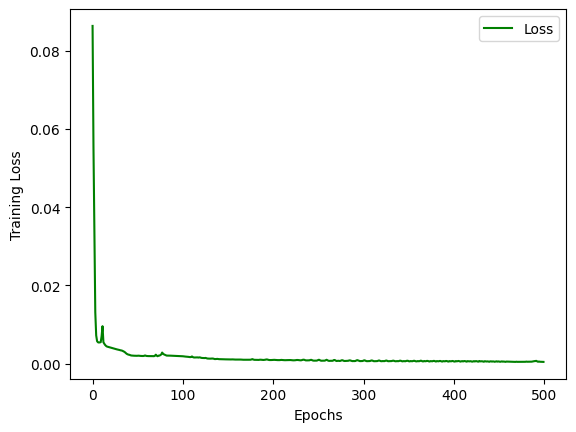

In [33]:
flg = plt.figure()
plt.plot(range(epoch+1),trainLoss,'g-',label = 'Loss')
plt.legend(loc ='best')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

In [34]:
# functions to show an image

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

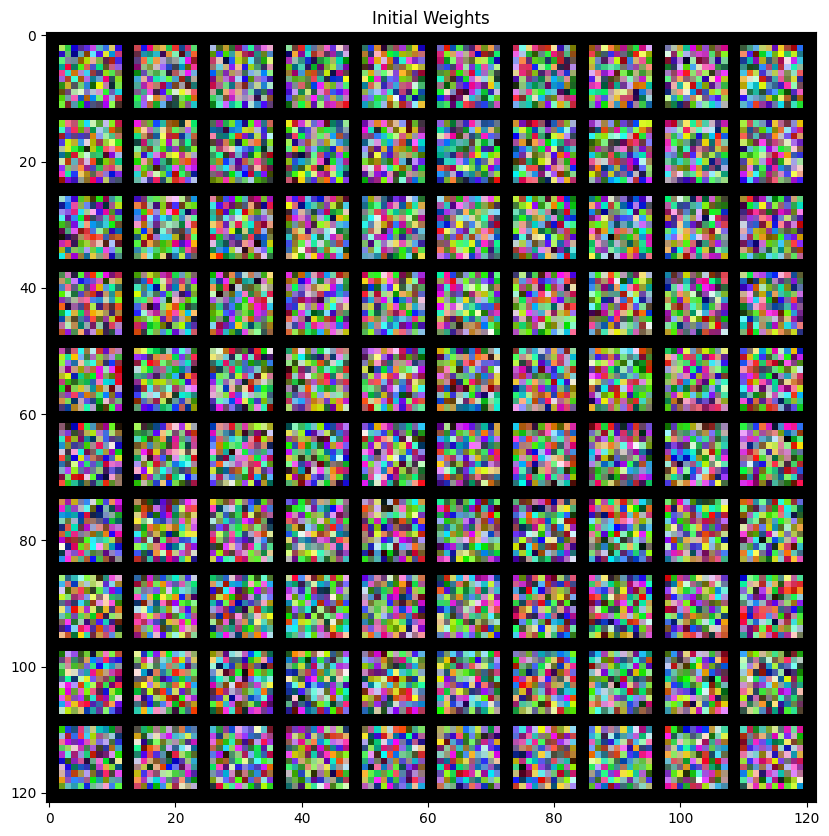

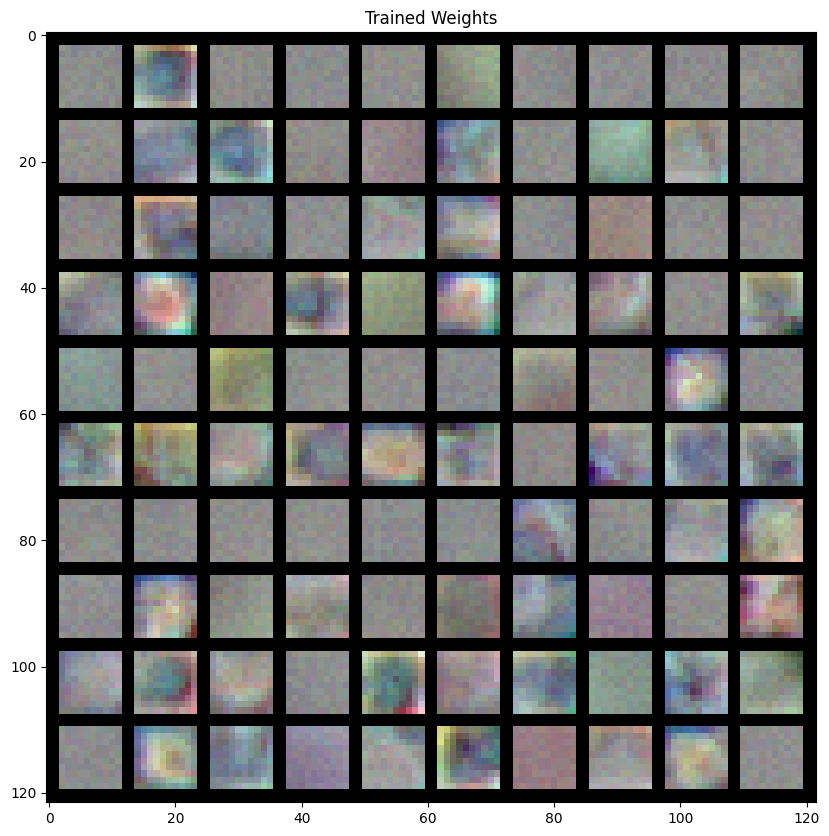

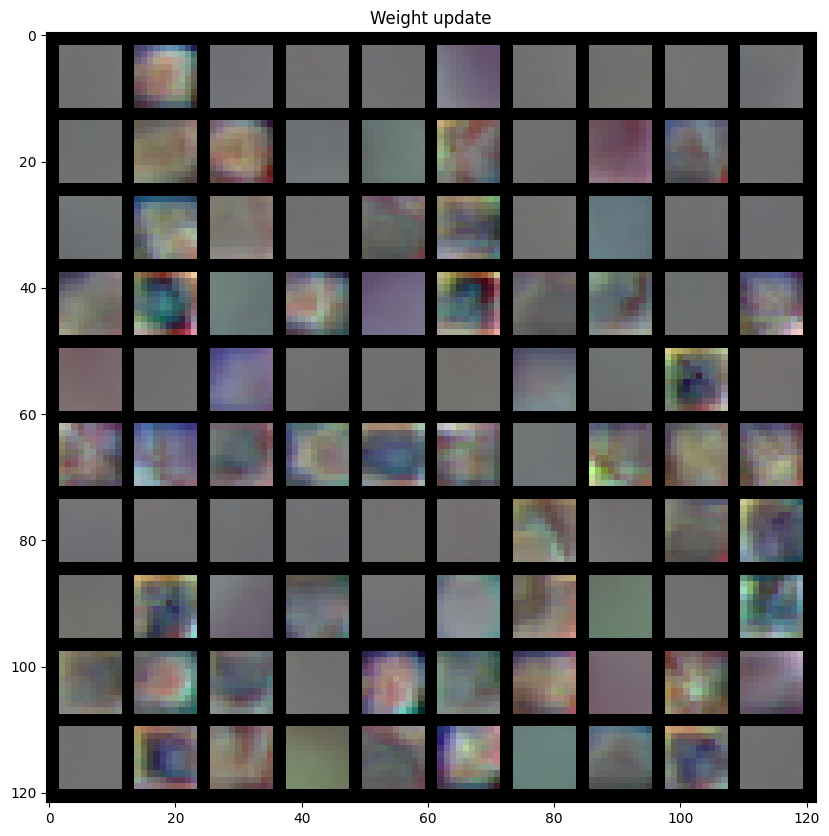

In [35]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)


init_weights = init_weights.view(100,3,10,10)
trained_weights = trained_weights.view(100,3,10,10)

if use_gpu:
    init_weights = init_weights.cpu()
    trained_weights = trained_weights.cpu()

d_weights = init_weights - trained_weights
d_weights = d_weights.view(100,3,10,10)


imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

In [37]:
#Modifying the autoencoder for classification:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
net = net.double().to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [38]:
#Train Classifier:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [57]:
iterations = 500000 #1000
BatchSize = 100000000
trainLoss = []
for epoch in range(iterations): # loop over the dataset multiple times
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100000 == 0:
        print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration: 1 / 500000  ;  Training Loss: 0.000000 
At Iteration: 100001 / 500000  ;  Training Loss: 0.000000 
At Iteration: 200001 / 500000  ;  Training Loss: 0.000000 
At Iteration: 300001 / 500000  ;  Training Loss: 0.000000 
At Iteration: 400001 / 500000  ;  Training Loss: 0.000000 
Finished Training


Text(0, 0.5, 'Training loss')

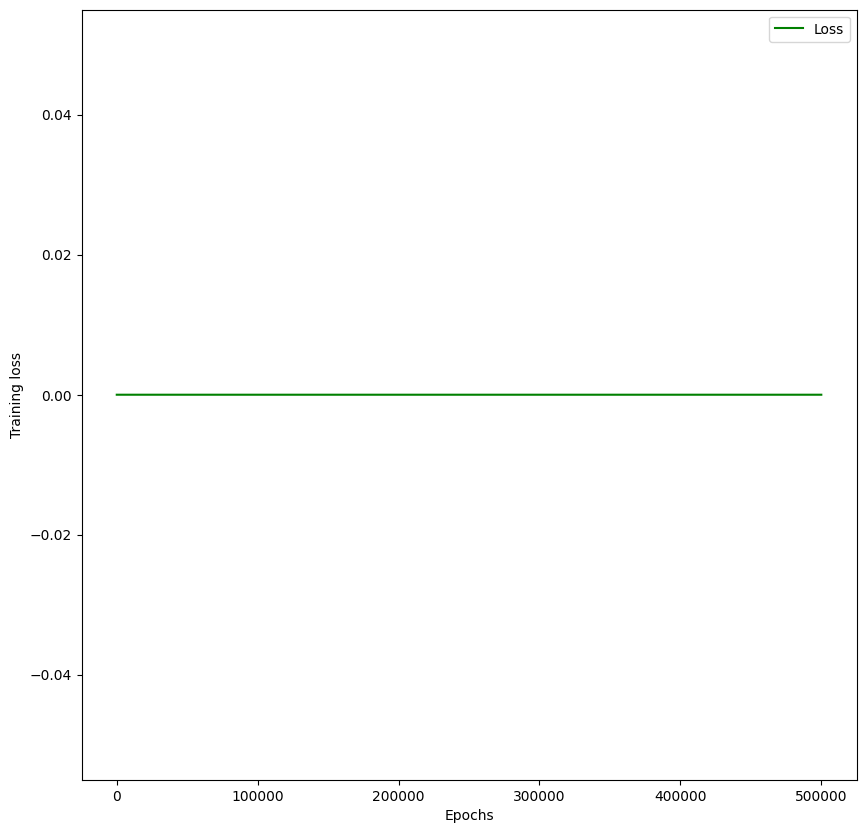

In [58]:
fig = plt.figure()
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

In [59]:
#Testing Performance:
TestDatapath = "C:\\Users\\enigma\\My Drive\\SEM V\\MP-III Retinal Vessel Segmentation\\Jupyter Folder\\Retina-Blood-Vessel-Segmentation-in-PyTorch\\UNET\\DRIVE\\test\\images\\"  # Test Image Data Path
#TestLabelpath = '/content/drive/MyDrive/Eye Dataset/datasets/test/mask/'  # Test Image Manual Label

In [60]:
os.path.exists(TestDatapath)

True

In [61]:
# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '01_test.tif')
imD = np.array(imD)
imD = imD/255.0


In [62]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(int(imD.shape[0]/patchH)):
    for j in range(int(imD.shape[1]/patchW)):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(TestTensor.double().to(device))
        if device == "cuda":
            outArr = out.data.cpu()
        outArr = outArr.numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

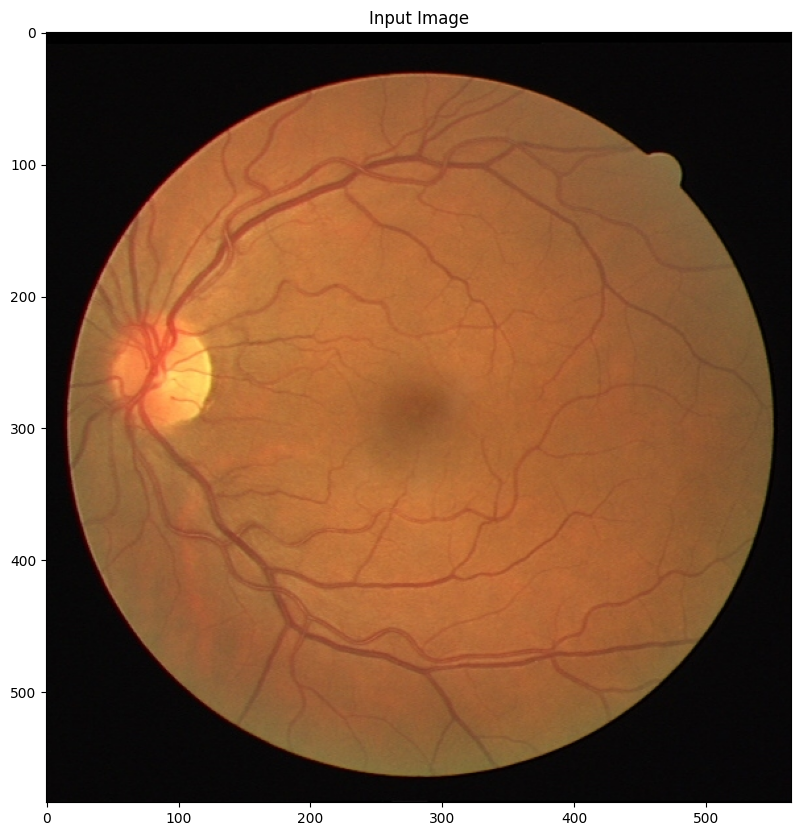

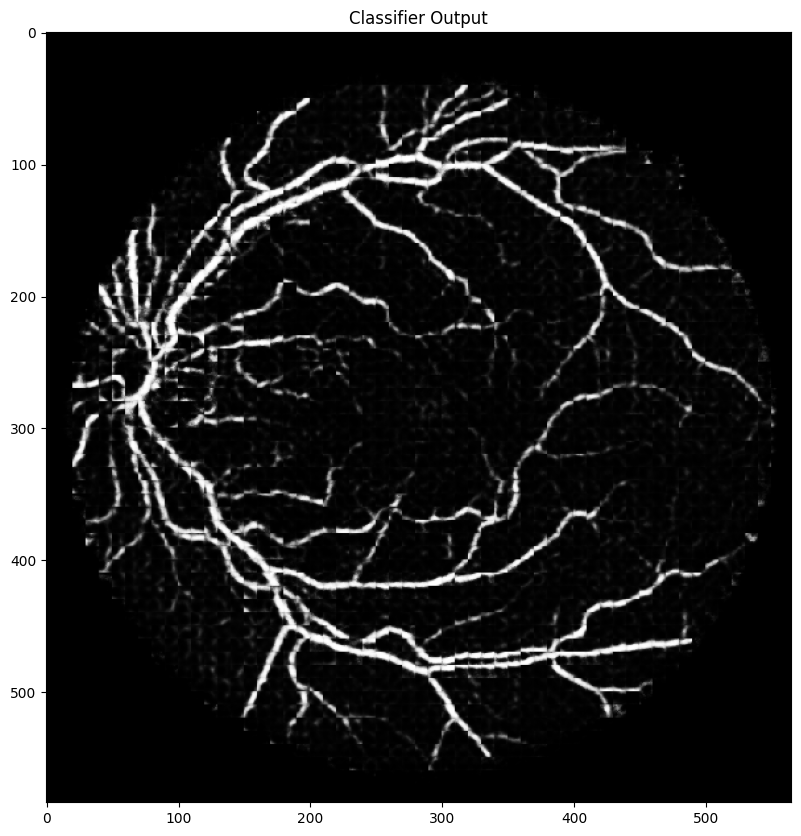

In [63]:
# Display results

plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(imout, 'gray')